In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from os import listdir


In [2]:
data_path = 'fd-1kpc-9.6sm-0-overlaid.csv/npy0'
file_list = listdir(data_path)
file_list.sort()


In [ ]:
siglist=[]
for items in file_list:
    data = np.load( os.path.join( data_path, items ) )
    siglist.append(data['sig'])

sigindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==1]
bkgindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==0]

In [4]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
class MyDataset(Dataset):
    def __init__(self, data_path_, file_list_):
        self.data_path = data_path_
        self.file_list = file_list_
        self.len = len(file_list_)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        data = np.load( os.path.join( self.data_path, file_name ) )
        return torch.from_numpy(data['imxz'][None, :, :]).to(torch.float)/4096, torch.from_numpy(data['imyz'][None, :, :]).to(torch.float)/4096, torch.from_numpy(data['sig']).to(torch.long)
    def __len__(self):
        return self.len

mydataset = MyDataset(data_path, file_list)
batch_size_train = 6
batch_size_test = 4


train_size = int(0.8 * len(mydataset))
test_size = len(mydataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)                

In [5]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(1, 64, 5) 
        self.conv1_2 = nn.Conv2d(1, 64, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2_1 = nn.Conv2d(64, 16, 5)
        self.conv2_2 = nn.Conv2d(64, 16, 5)
        self.fc1_1 = nn.Linear(16 * 221 * 93, 10)
        self.fc1_2 = nn.Linear(16 * 221 * 93, 10)
        self.fc2= nn.Linear(20, 2)

    def forward(self, x1, x2):
        # x1, x2 shape: (896, 384)      channel = 1
        x1 = self.pool(F.relu(self.conv1_1(x1))) # shape: (896, 384)->(892, 380)->(446, 190)
        x1 = self.pool(F.relu(self.conv2_1(x1))) # shape: (446, 190)->(442, 186)->(221, 93)
        x1 = torch.flatten(x1, 1) # flatten all dimensions except batch 
        x1 = F.relu(self.fc1_1(x1))

        x2 = self.pool(F.relu(self.conv1_2(x2))) # shape: (896, 384)->(892, 380)->(446, 190)
        x2 = self.pool(F.relu(self.conv2_2(x2))) # shape: (446, 190)->(442, 186)->(221, 93)
        x2 = torch.flatten(x2, 1) # flatten all dimensions except batch 
        x2 = F.relu(self.fc1_2(x2))

        return self.fc2(torch.cat((x1, x2), 1))
net=Net().cuda()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
sum(p.numel() for p in net.parameters())

6631582

In [8]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [17]:
# Training
loss_list = []
alpha=0.2
epochs = 100

net.train()

for i in range(epochs):
    for (batch_idx, batch) in enumerate(trainloader):
        XZ_train_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_train_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_train_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        Netout = net.forward(XZ_train_batch, YZ_train_batch) # This will call the forward function, usually it returns tensors.
        #print(F.softmax(Netout))
        loss = criterion(Netout, sig_train_batch) # classification loss

        
        
        # Zero the gradients before running the backward pass.
        optimizer.zero_grad() 
        
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 50 == 0 or True:
            #print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))


Epoch: 0, batch: 0 Loss: 0.1207
Epoch: 0, batch: 1 Loss: 0.8053
Epoch: 0, batch: 2 Loss: 0.4629
Epoch: 0, batch: 3 Loss: 0.4628
Epoch: 0, batch: 4 Loss: 0.1211
Epoch: 0, batch: 5 Loss: 0.1211
Epoch: 0, batch: 6 Loss: 0.1211
Epoch: 0, batch: 7 Loss: 0.4628
Epoch: 0, batch: 8 Loss: 0.4628
Epoch: 0, batch: 9 Loss: 0.1209
Epoch: 0, batch: 10 Loss: 0.1208
Epoch: 0, batch: 11 Loss: 0.4630
Epoch: 0, batch: 12 Loss: 0.4630
Epoch: 0, batch: 13 Loss: 0.8056
Epoch: 0, batch: 14 Loss: 0.4630
Epoch: 0, batch: 15 Loss: 0.8051
Epoch: 0, batch: 16 Loss: 0.4628
Epoch: 0, batch: 17 Loss: 1.1454
Epoch: 0, batch: 18 Loss: 0.1219
Epoch: 0, batch: 19 Loss: 0.4622
Epoch: 0, batch: 20 Loss: 0.4621
Epoch: 0, batch: 21 Loss: 0.8007
Epoch: 0, batch: 22 Loss: 0.1236
Epoch: 0, batch: 23 Loss: 0.1240
Epoch: 0, batch: 24 Loss: 0.1243
Epoch: 0, batch: 25 Loss: 0.4613
Epoch: 0, batch: 26 Loss: 0.1246
Epoch: 0, batch: 27 Loss: 0.1247
Epoch: 0, batch: 28 Loss: 0.1246
Epoch: 0, batch: 29 Loss: 0.7980
Epoch: 0, batch: 30 

KeyboardInterrupt: 

In [17]:
siglist=[]
for items in file_list:
    data = np.load( os.path.join( data_path, items ) )
    siglist.append([items, data['sig']])

In [ ]:
siglist

In [20]:
with torch.no_grad():
    # Prediction
    preds = []
    reals = []

    for (batch_idx, batch) in enumerate(testloader):
        XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
        #print(Netout.shape)
        prediction=F.softmax(Netout, dim=1).argmax(dim=1)
        #print(predictor)

        preds.append(prediction.cpu().detach().numpy())
        reals.append(sig_test_batch.cpu().detach().numpy())
    preds=np.array(preds)
    reals=np.array(reals)

In [21]:
np.sum(preds.flatten()==reals.flatten())

343

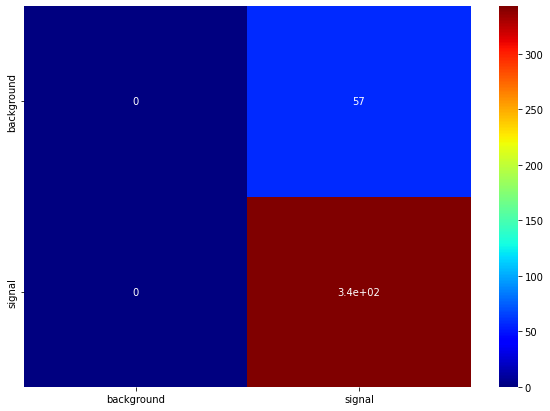

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(reals.flatten(), preds.flatten()), index = ['background', 'signal'],
                  columns = ['background', 'signal'])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.heatmap(df_cm, annot=True, cmap="jet")
plt.show()

# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

In [11]:
np.sum(reals.flatten())

343

In [26]:
torch.save(net, './model_save_train.pth')

In [39]:
net = torch.load('./model_save_train.pth')


In [24]:
confusion_matrix(reals.flatten(), preds.flatten())

array([[ 45,  12],
       [  8, 335]], dtype=int64)